In [1]:
import tensorflow as tf
import tensorflow.contrib.rnn as tf_rnn
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# 10 classes, 0 - 9
batch_size = 128
hm_epochs = 3

n_nodes_hl1 = 500
n_nodes_hl2 = 500
n_nodes_hl3 = 500
beta = 0.01

rnn_size = 10
chunk_size = 28
n_chunks = 28

image_size = 28

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [2]:
x = tf.placeholder(tf.float32, [None, image_size * image_size]) # try getting the same image
y = tf.placeholder(tf.float32, (None, image_size * image_size))

In [3]:
def dnn_model(x):
    hidden_1_layer = {'weights' : tf.Variable(tf.random_normal([784, n_nodes_hl1])),
                       'biases' : tf.Variable(tf.random_normal([n_nodes_hl1]))}
    reg1 = tf.nn.l2_loss(hidden_1_layer['weights'])

    hidden_2_layer = {'weights': tf.Variable(tf.random_normal([n_nodes_hl1, n_nodes_hl2])),
                       'biases': tf.Variable(tf.random_normal([n_nodes_hl2]))}
    reg2 = tf.nn.l2_loss(hidden_2_layer['weights'])

    hidden_3_layer = {'weights': tf.Variable(tf.random_normal([n_nodes_hl2, n_nodes_hl3])),
                       'biases': tf.Variable(tf.random_normal([n_nodes_hl3]))}
    reg3 = tf.nn.l2_loss(hidden_3_layer['weights'])

    output_layer = {'weights': tf.Variable(tf.random_normal([n_nodes_hl3, 784])),
                       'biases': tf.Variable(tf.random_normal([784]))}
    reg0 = tf.nn.l2_loss(output_layer['weights'])

    l1 = tf.add(tf.matmul(x, hidden_1_layer['weights']), hidden_1_layer['biases'])
    l1 = tf.nn.relu(l1)
    

    l2 = tf.add(tf.matmul(l1, hidden_2_layer['weights']), hidden_2_layer['biases'])
    l2 = tf.nn.relu(l2)

    l3 = tf.add(tf.matmul(l2, hidden_3_layer['weights']), hidden_3_layer['biases'])
    l3 = tf.nn.relu(l3)

    output = tf.add(tf.matmul(l3, output_layer['weights']), output_layer['biases'])

    return reg1, reg2, reg3, output

In [4]:
def rnn_model(x):
    """
    The computation model
    """
    layer = {'weights' : tf.Variable(tf.random_normal([rnn_size, 784])),
             'biases' : tf.Variable(tf.random_normal([784]))}

    x = tf.transpose(x, [1,0,2])
    x = tf.reshape(x, [-1, chunk_size])
    x = tf.split(x, n_chunks, 0)

    lstm_cell = tf_rnn.BasicLSTMCell(rnn_size)

    outputs, states = tf.contrib.rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    output = tf.add(tf.matmul(outputs[-1], layer['weights']), layer['biases'])

    return output


In [5]:
def cnn_model(x):
    weights = {'W_fc': tf.Variable(tf.random_normal([28*28, 1024])),
               'out': tf.Variable(tf.random_normal([1024, image_size * image_size]))}
    
    biases = {'b_fc': tf.Variable(tf.random_normal([1024])),
              'out': tf.Variable(tf.random_normal([image_size * image_size]))}
    
    x = tf.reshape(x, shape=[-1, 28, 28, 1])
    
    conv1 = tf.layers.conv2d(
                            inputs=x,
                            filters=32,
                            kernel_size=[20, 20],
                            padding="same",
                            activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    print(pool1.shape)
    
    conv2 = tf.layers.conv2d(
                            inputs=pool1,
                            filters=64,
                            kernel_size=[10, 10],
                            padding="same",
                            activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    print(pool2.shape)
    
    conv3 = tf.layers.conv2d(
                            inputs=pool2,
                            filters=128,
                            kernel_size=[5, 5],
                            padding="same",
                            activation=tf.nn.relu)
    
    conv4 = tf.layers.conv2d_transpose(
                                      inputs=conv3,
                                      filters=64,
                                      kernel_size=[5, 5],
                                      padding="same")
    print(conv4.shape)
    
    conv5 = tf.layers.conv2d_transpose(
                                      inputs=conv4,
                                      filters=32,
                                      kernel_size=[10, 10],
                                      padding="same")
    print(conv5.shape)
    
    conv6 = tf.layers.conv2d_transpose(
                                      inputs=conv5,
                                      filters=16,
                                      kernel_size=[28, 28],
                                      padding="same")
    print(conv6.shape)
    
    output = tf.nn.softmax(conv6)
    
    return tf.reshape(output, (-1 ,784))

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

def train_neural_network(x):
    prediction = cnn_model(x)
    cost = tf.reduce_mean(tf.losses.mean_squared_error(y, prediction))

    # default learning rate = 0.001
    optimizer = tf.train.AdamOptimizer().minimize(cost)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        # now we are done initializing our computation graph

        for epoch in range(hm_epochs):
            epoch_loss = 0
            for _ in range(int(mnist.train.num_examples//batch_size)):
                epoch_x, _ = mnist.train.next_batch(batch_size)
                epoch_y = []
                for i in range(len(epoch_x)):
                    epoch_y.append([0 if x==0 else 1 for x in epoch_x[i]])
                _, c = sess.run([optimizer, cost], feed_dict={x: epoch_x, y: epoch_y})
                prediction_0 = prediction.eval(feed_dict={x: epoch_x[0].reshape(-1, 784)})
                plt.imshow(epoch_x[0].reshape(28, 28), cmap='gray')
                plt.show()
                plt.imshow(prediction_0.reshape(28, 28), cmap='gray')
                plt.show()
                epoch_loss += c
            print('Epoch', epoch, 'completed out of', hm_epochs, '\nloss: ', epoch_loss)

        correct = tf.equal(prediction, y)
        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        print('Accuracy:', accuracy.eval({x: mnist.test.images, y: mnist.test.images}))

(?, 14, 14, 32)
(?, 7, 7, 64)
(?, 7, 7, 64)
(?, 7, 7, 32)
(?, 7, 7, 16)


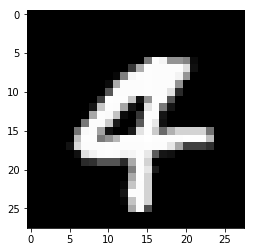

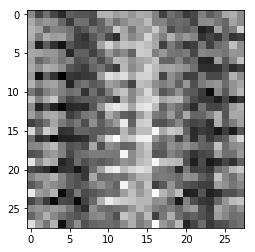

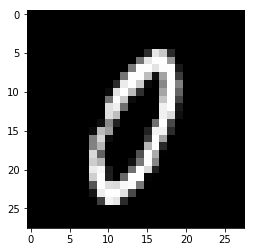

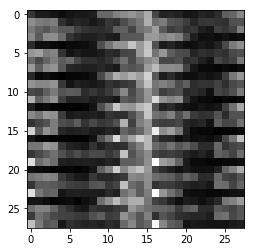

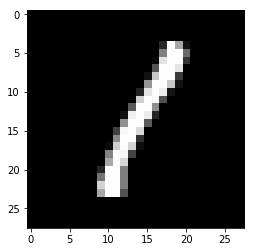

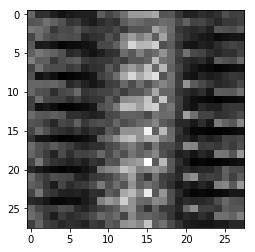

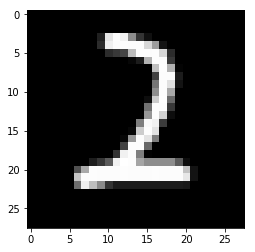

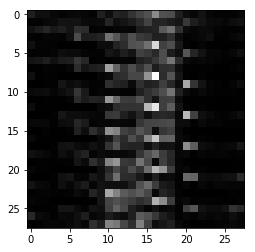

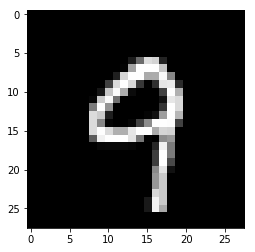

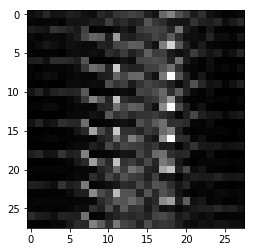

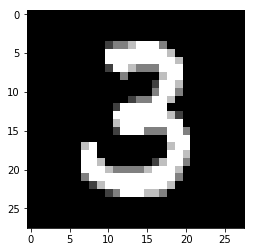

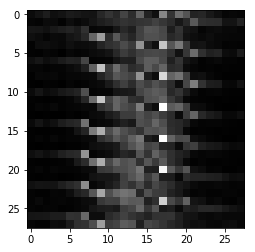

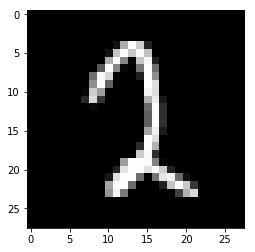

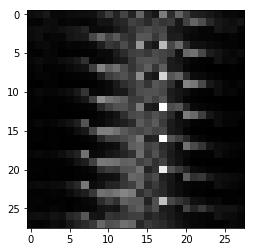

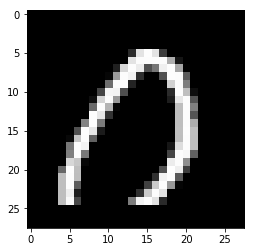

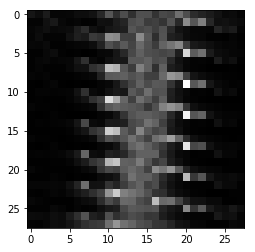

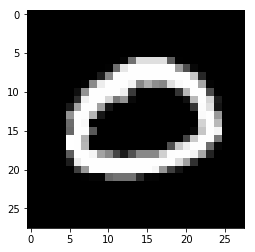

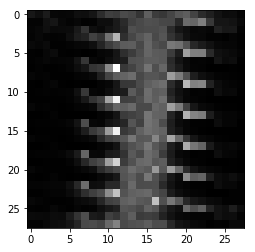

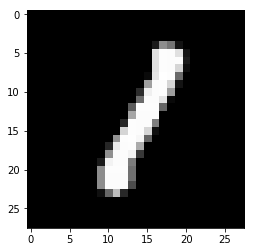

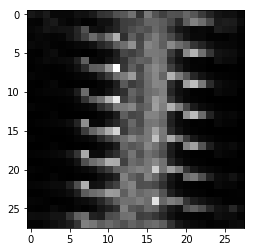

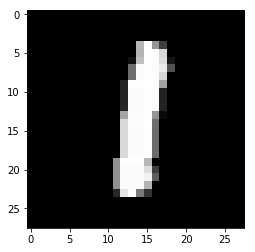

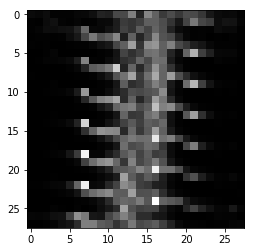

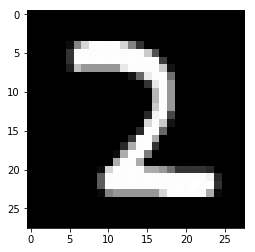

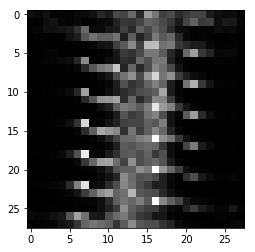

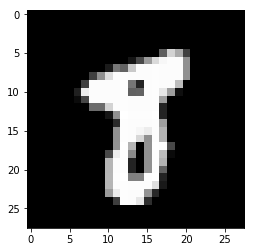

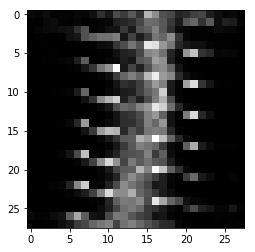

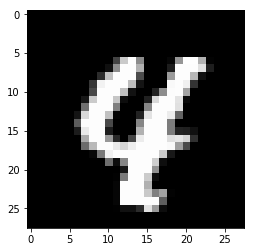

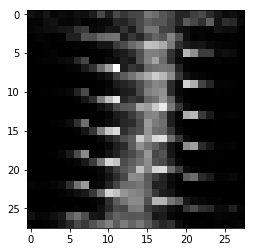

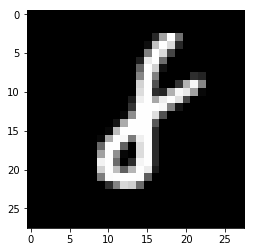

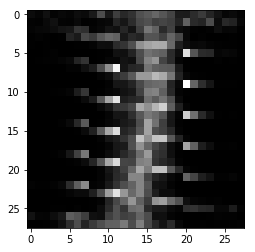

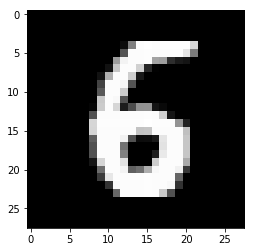

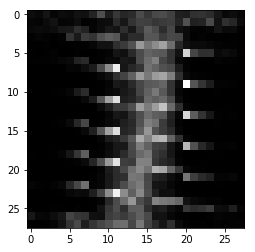

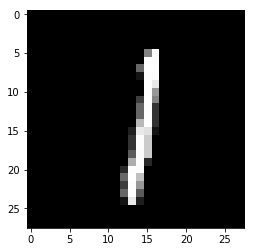

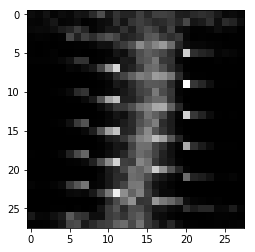

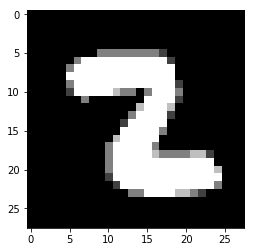

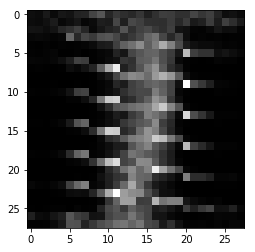

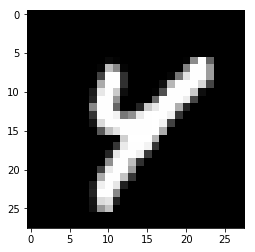

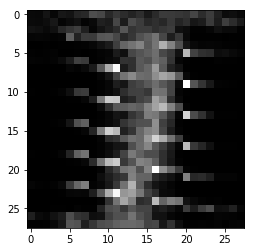

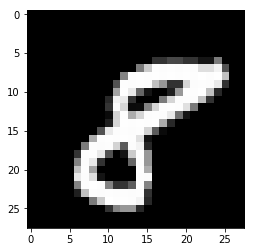

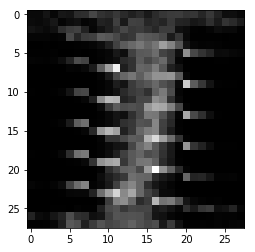

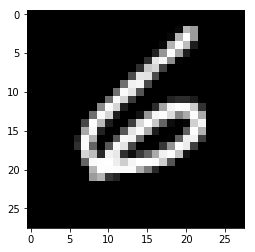

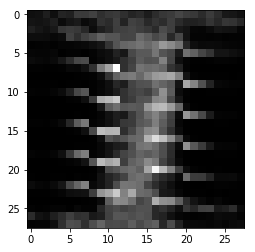

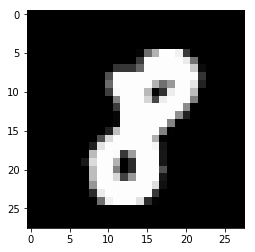

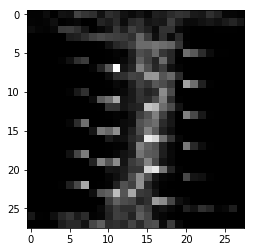

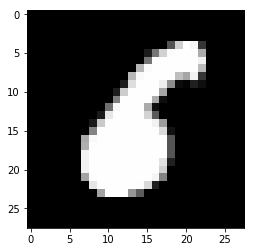

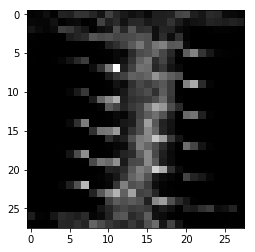

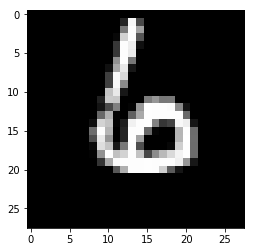

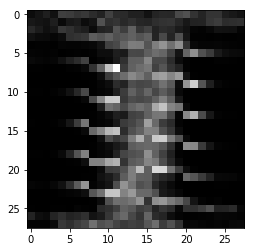

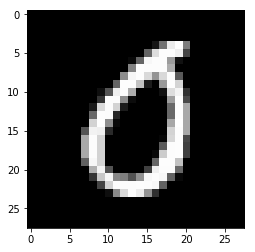

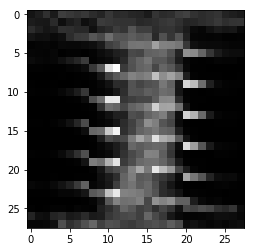

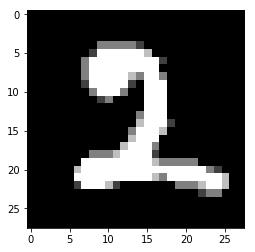

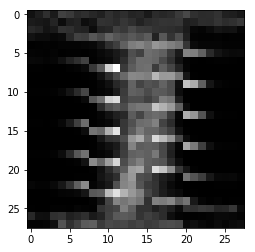

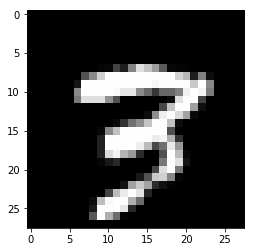

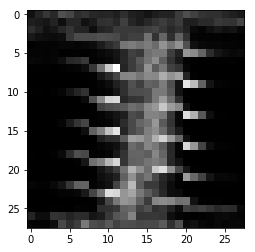

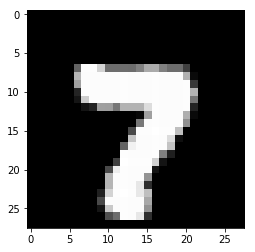

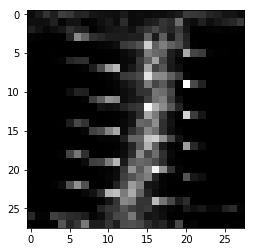

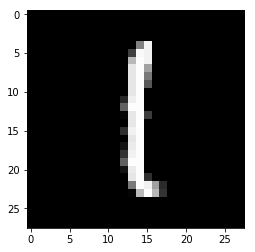

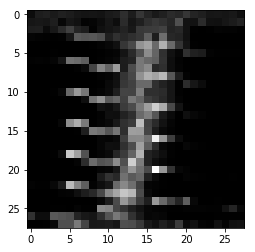

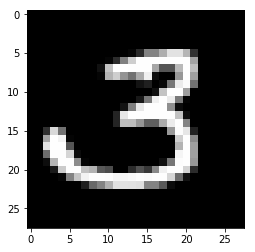

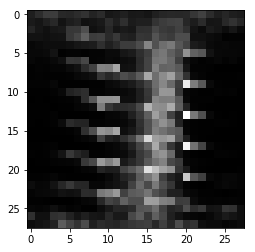

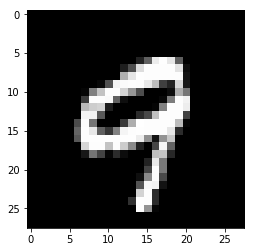

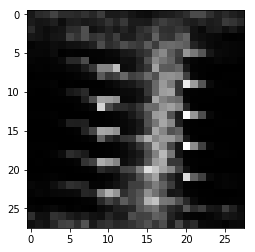

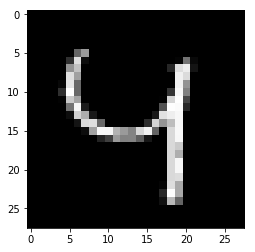

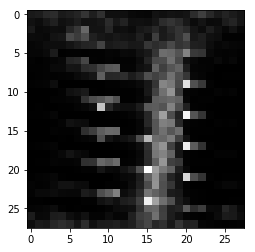

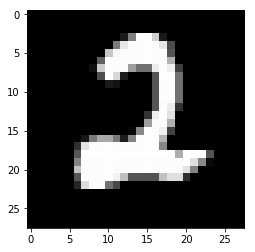

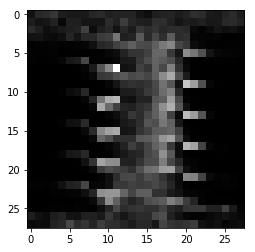

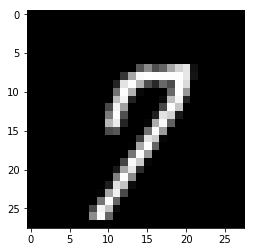

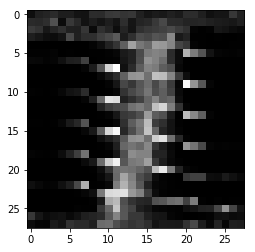

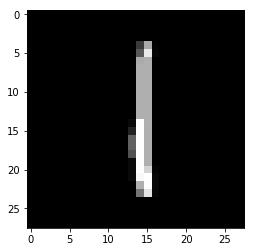

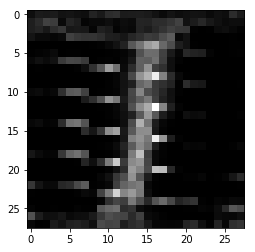

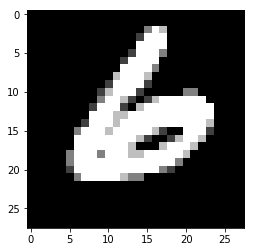

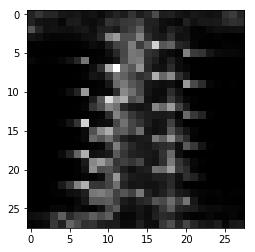

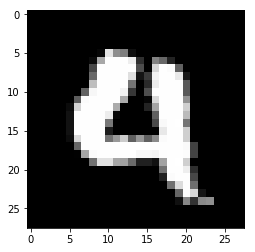

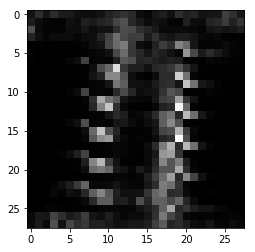

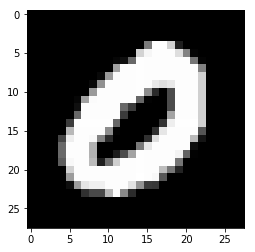

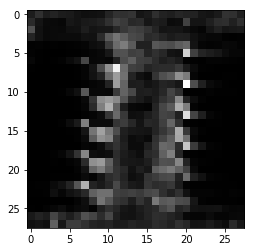

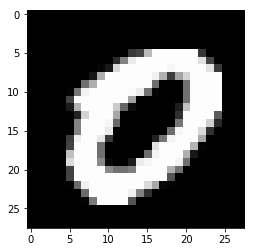

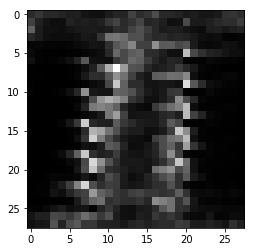

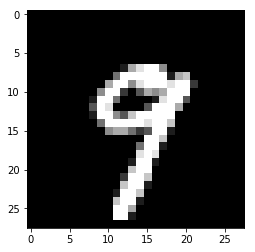

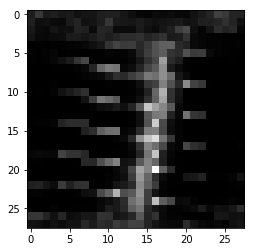

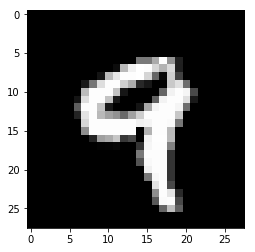

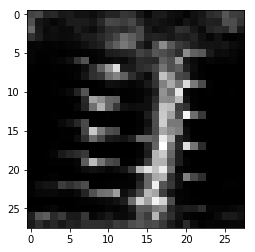

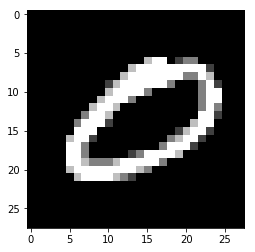

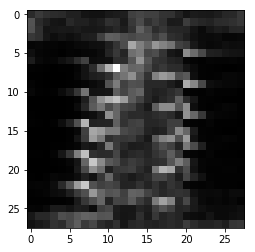

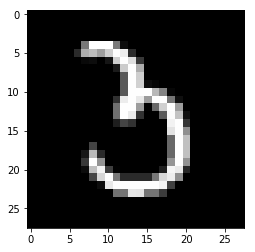

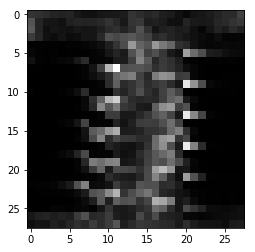

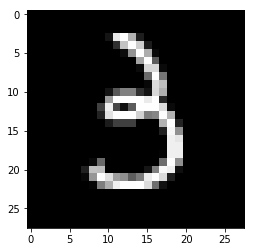

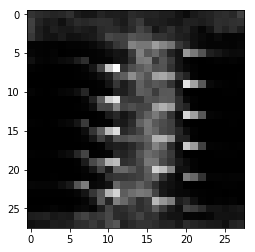

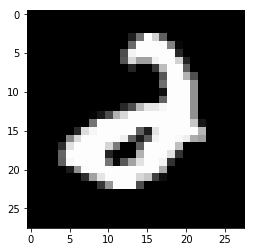

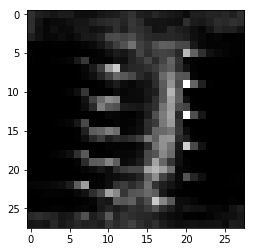

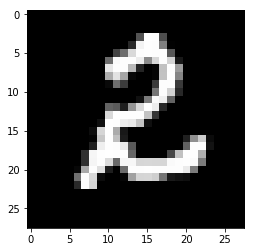

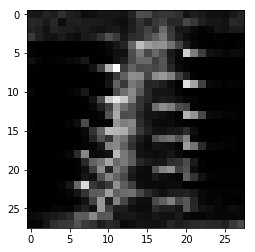

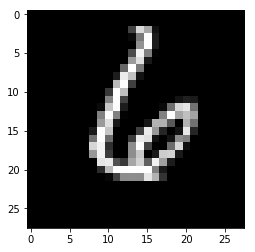

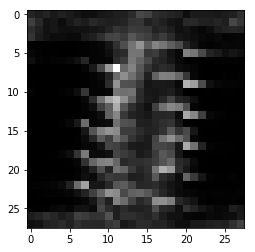

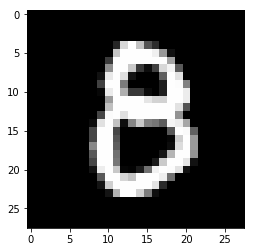

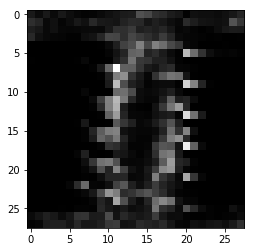

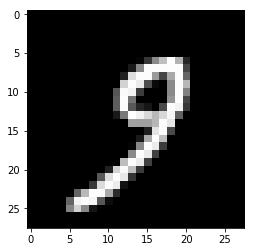

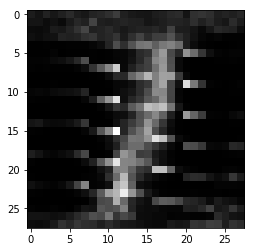

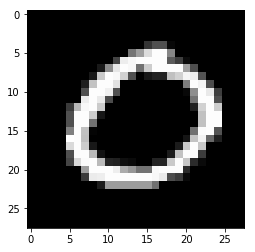

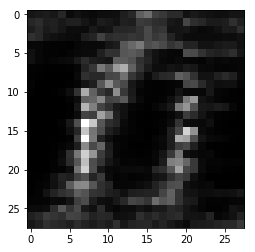

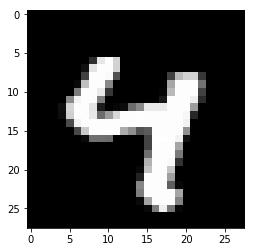

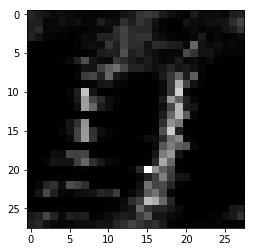

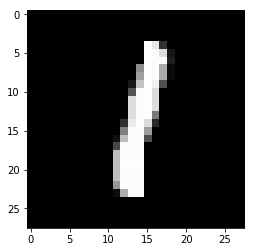

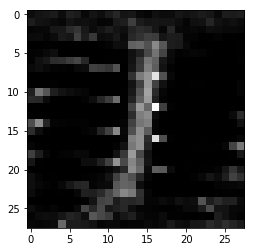

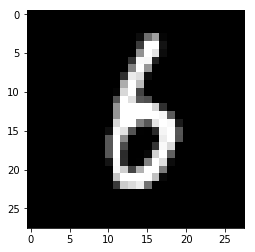

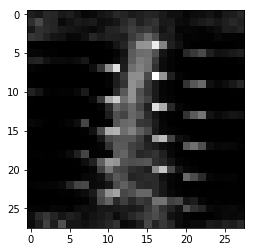

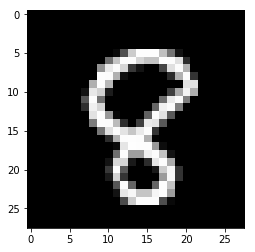

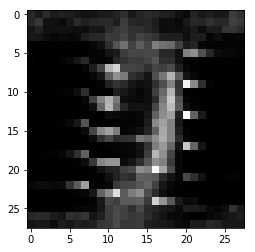

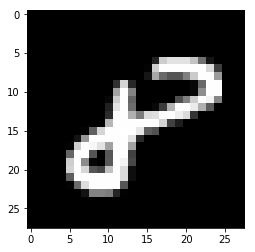

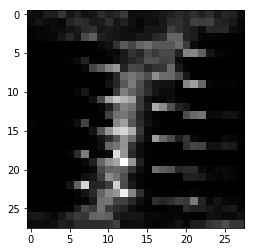

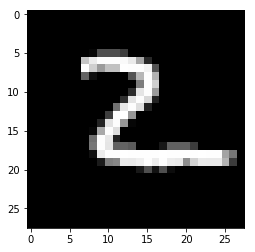

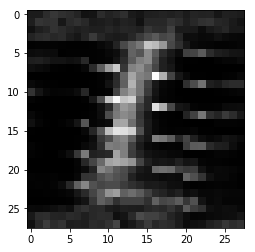

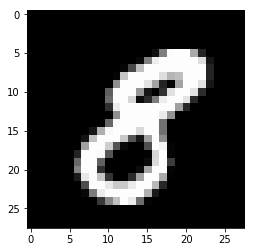

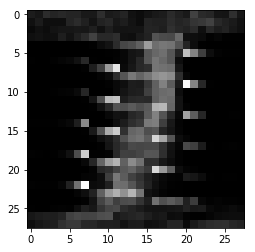

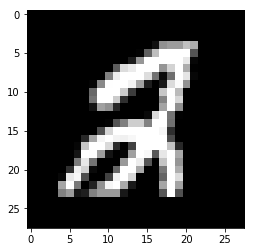

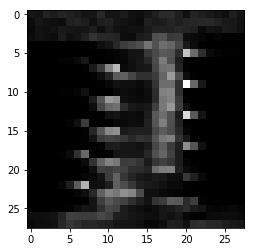

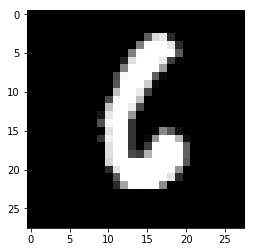

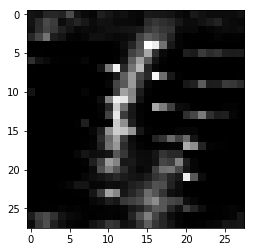

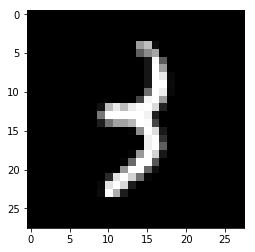

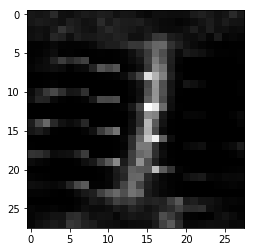

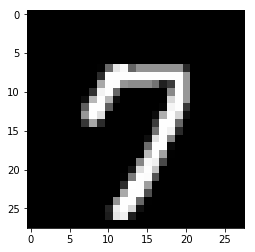

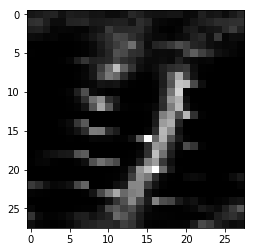

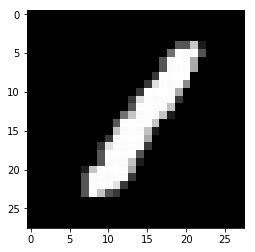

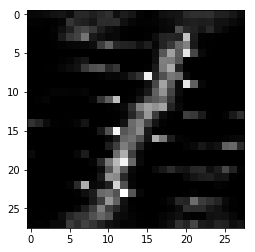

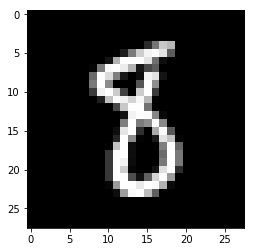

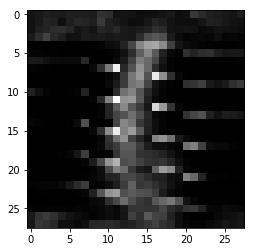

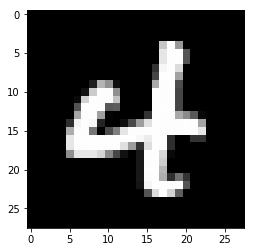

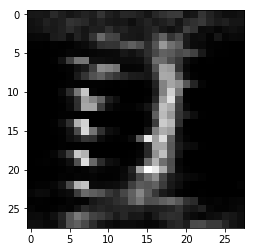

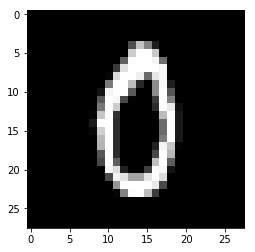

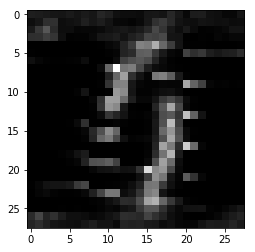

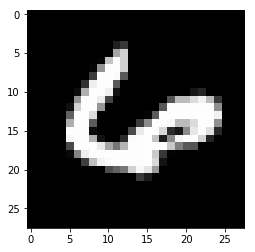

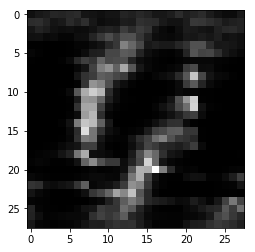

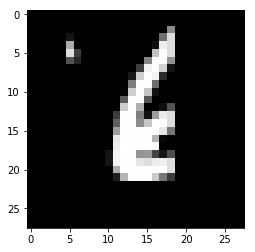

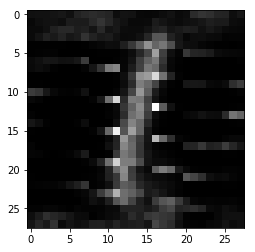

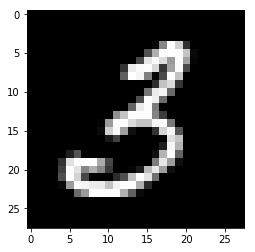

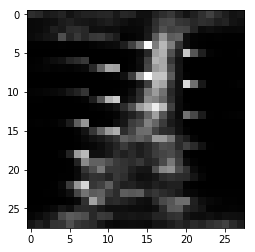

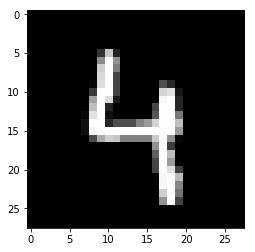

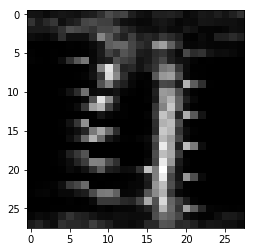

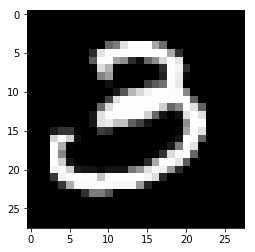

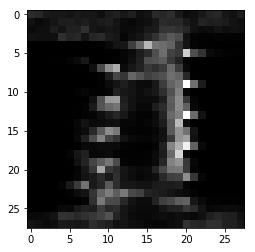

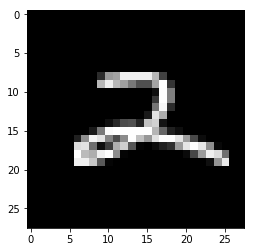

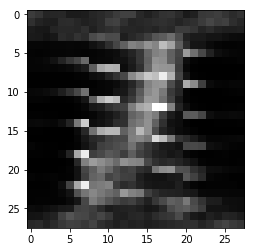

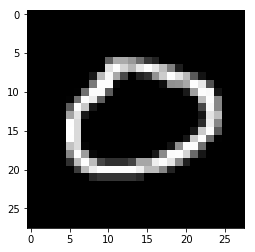

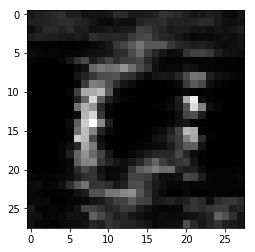

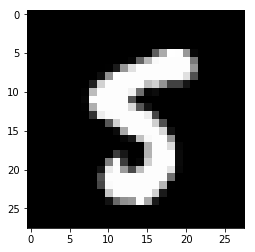

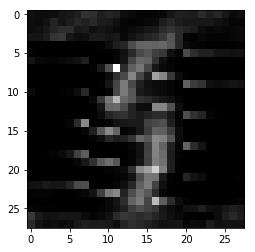

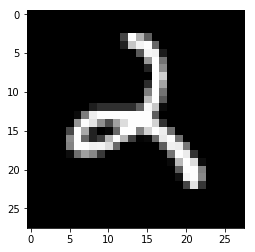

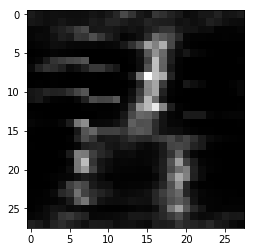

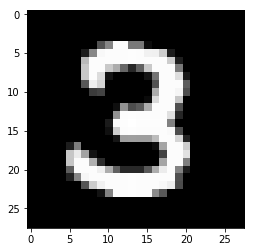

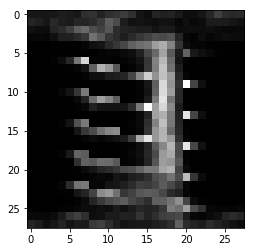

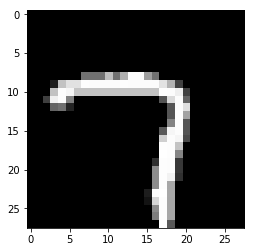

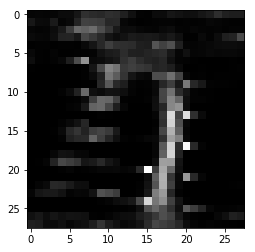

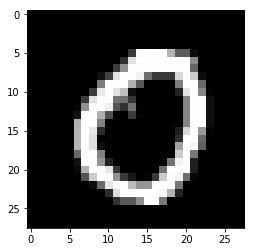

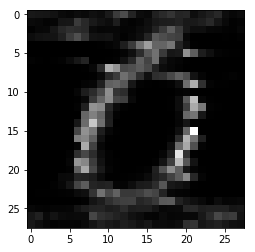

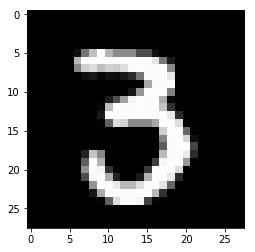

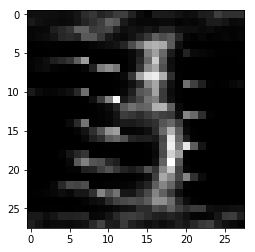

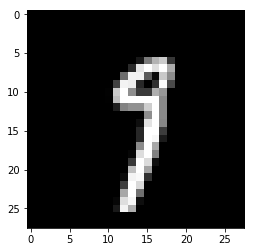

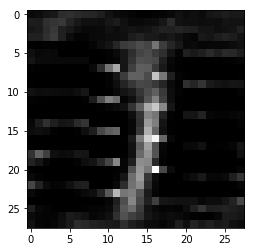

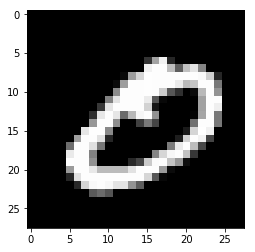

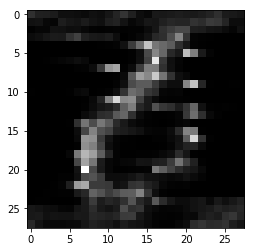

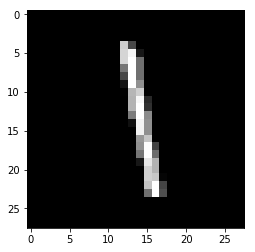

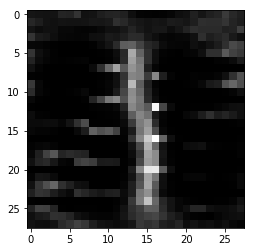

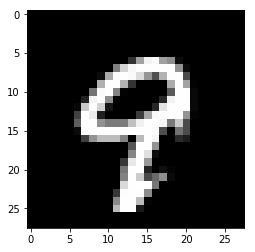

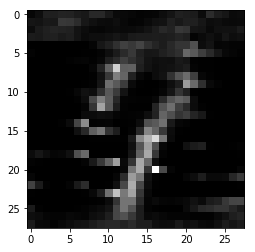

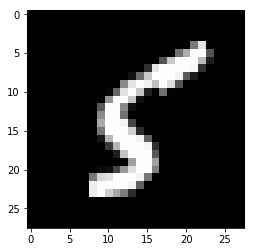

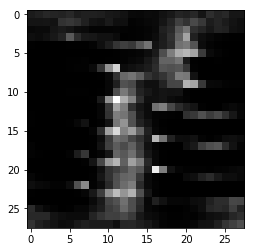

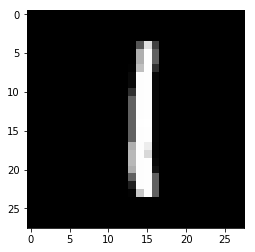

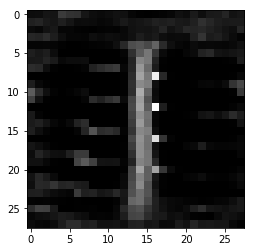

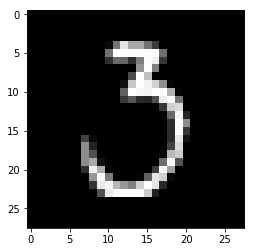

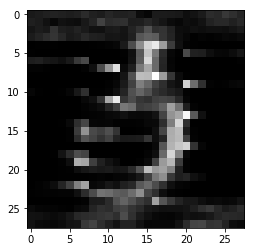

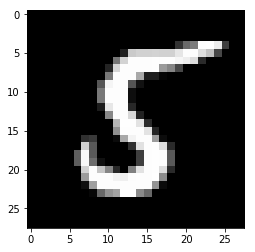

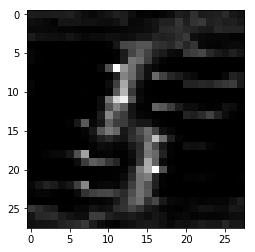

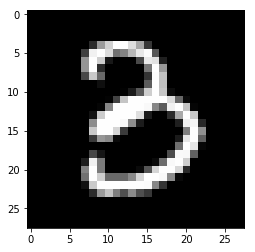

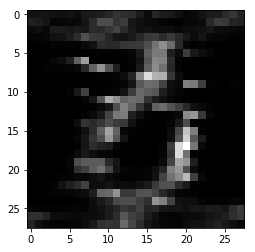

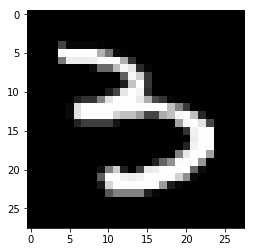

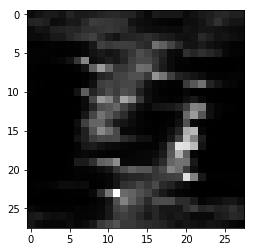

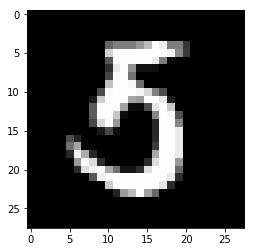

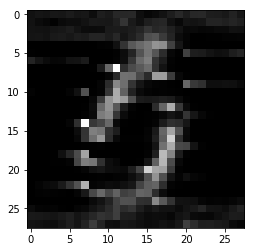

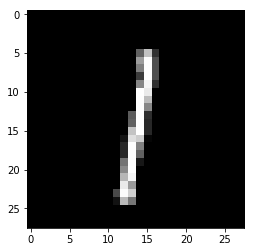

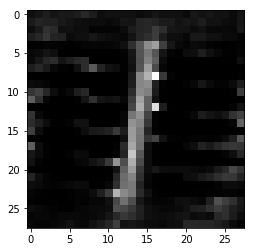

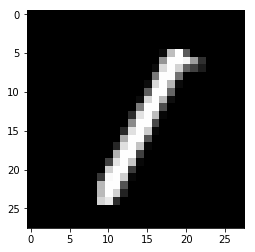

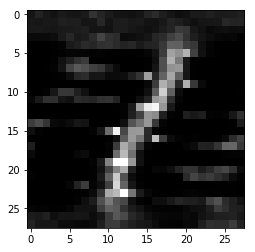

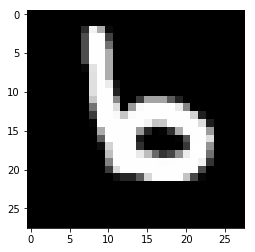

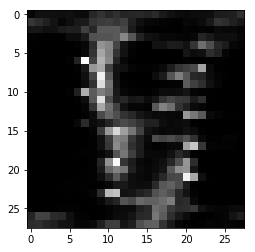

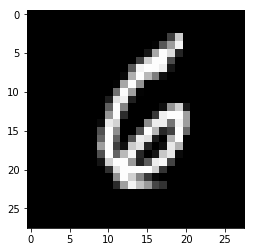

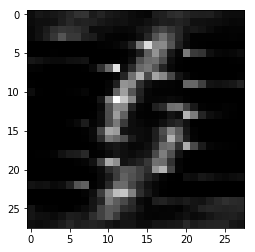

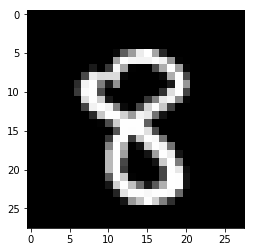

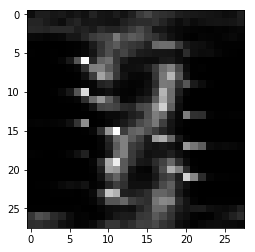

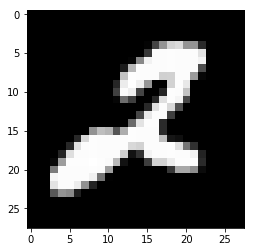

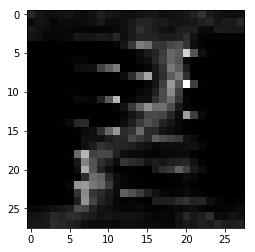

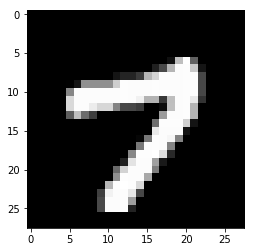

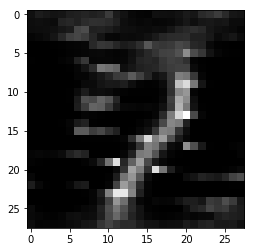

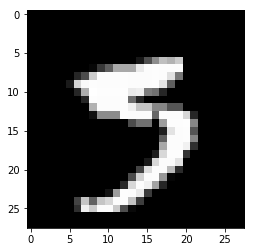

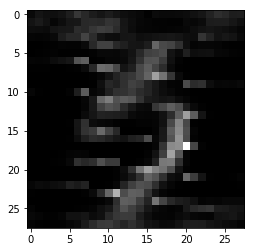

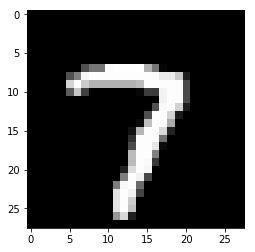

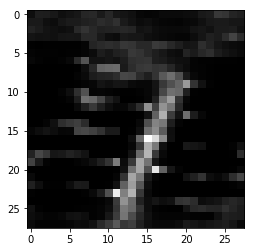

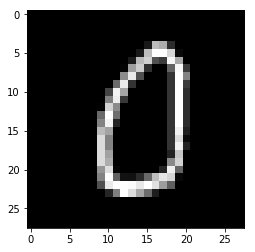

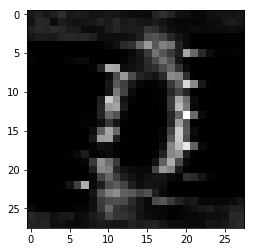

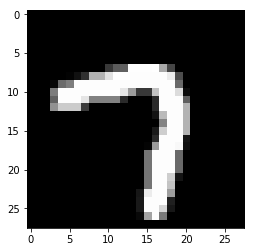

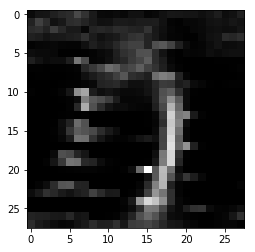

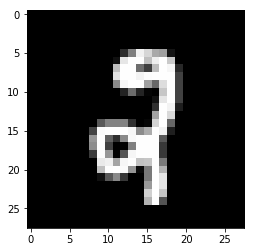

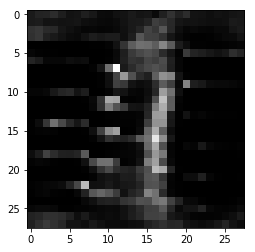

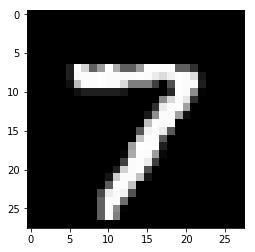

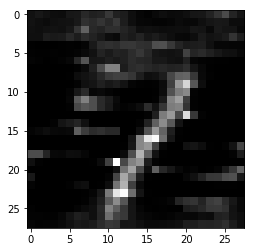

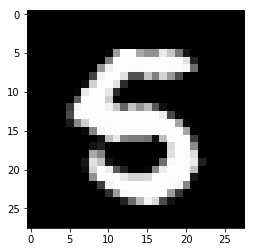

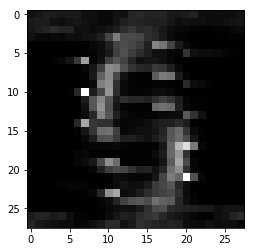

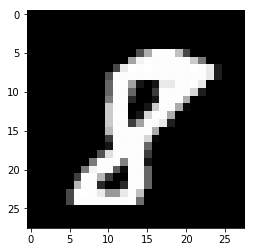

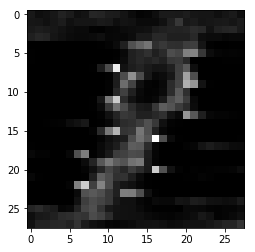

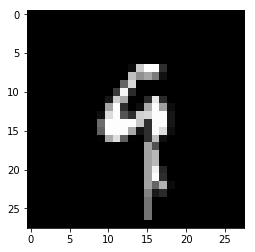

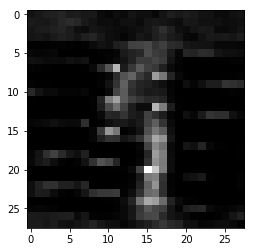

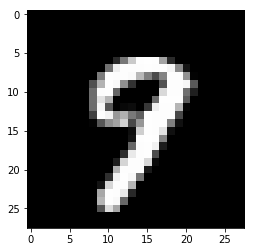

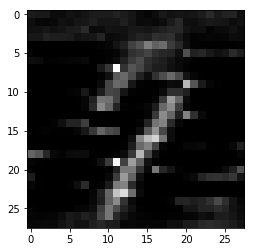

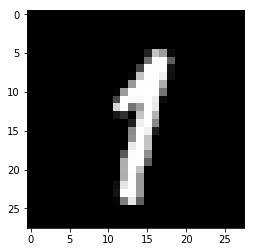

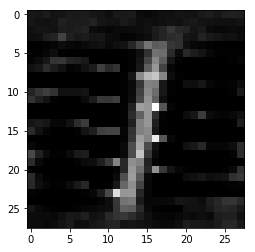

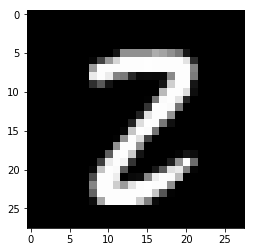

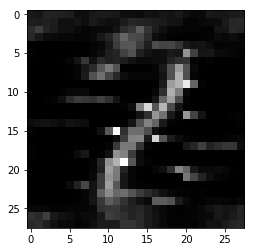

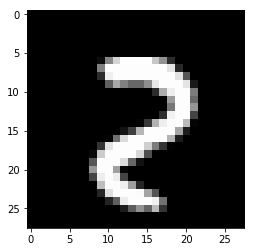

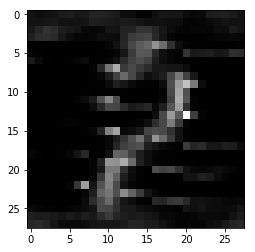

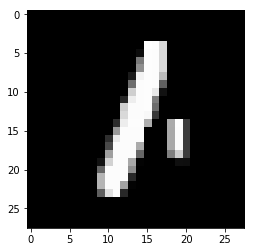

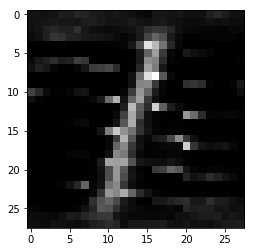

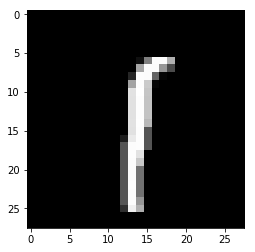

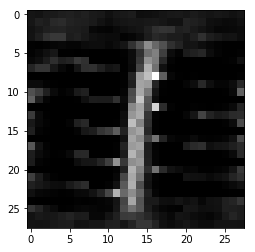

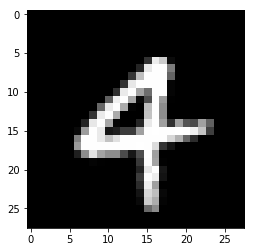

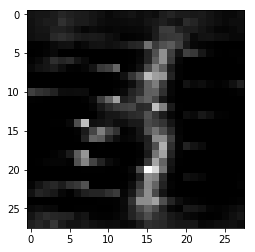

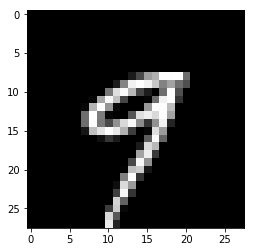

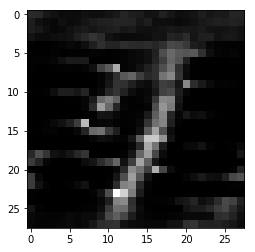

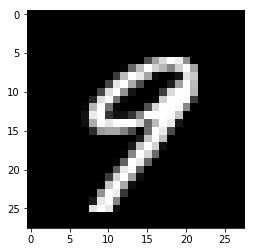

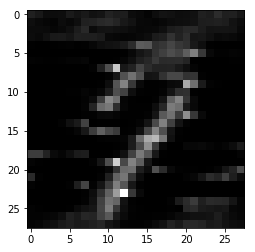

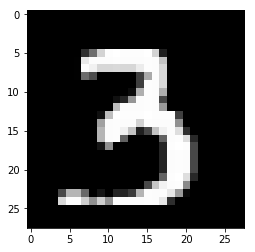

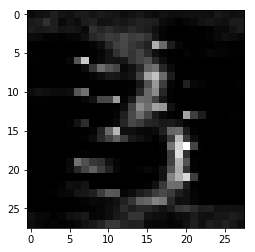

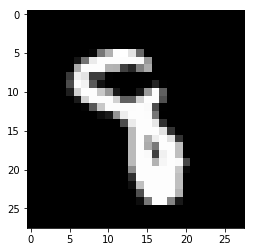

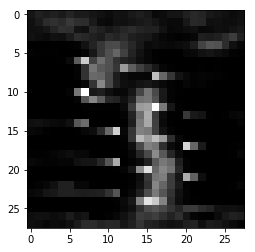

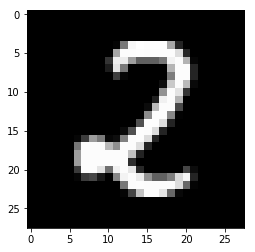

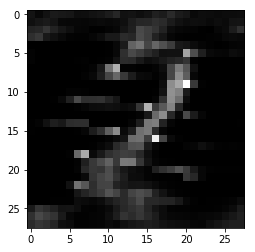

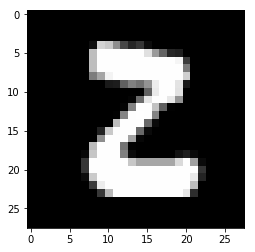

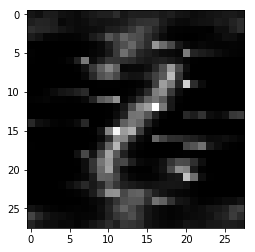

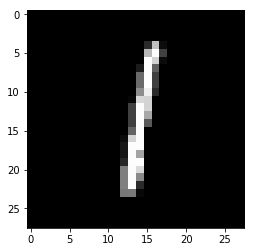

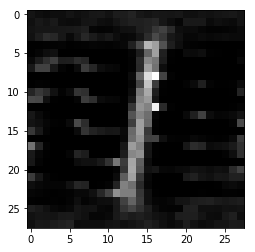

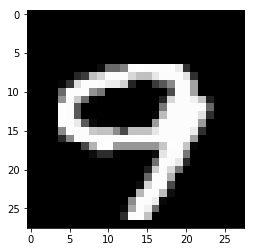

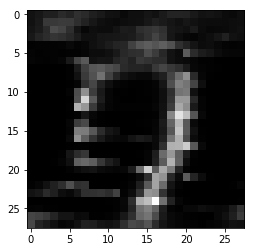

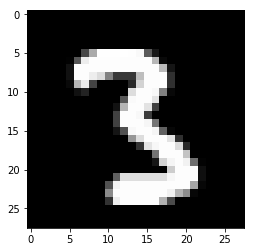

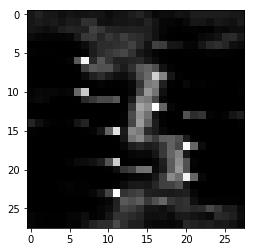

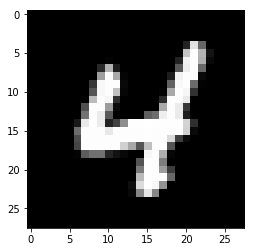

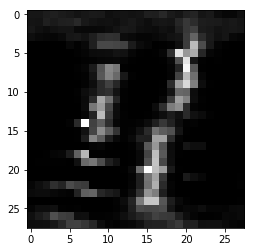

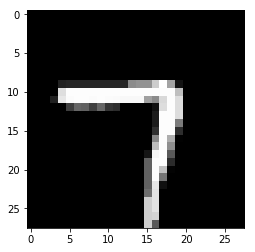

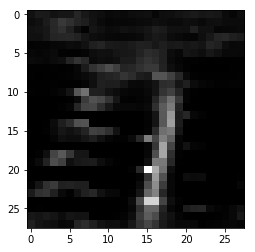

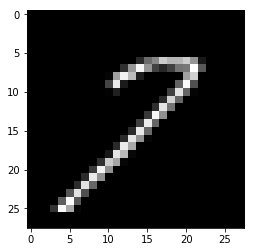

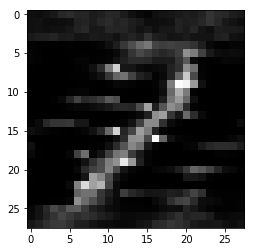

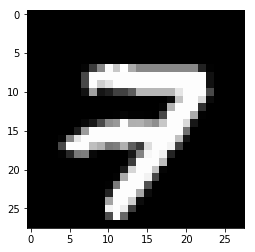

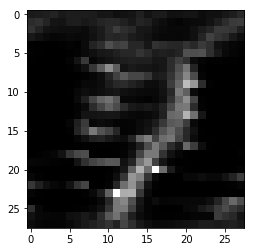

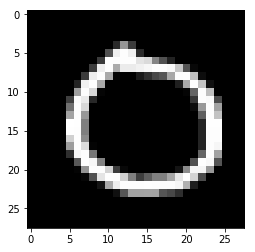

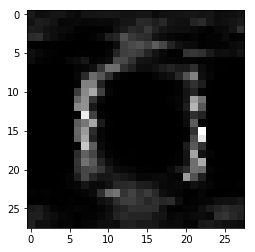

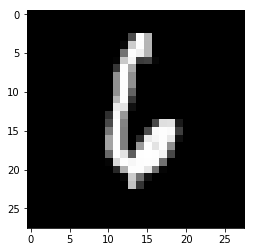

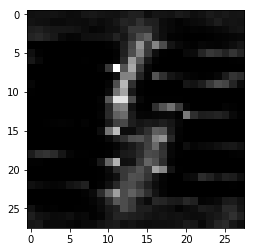

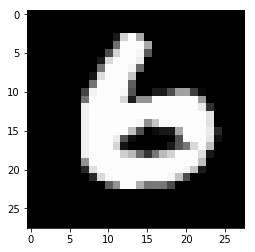

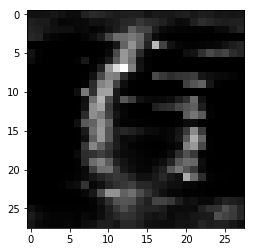

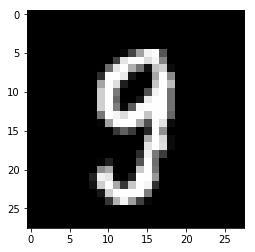

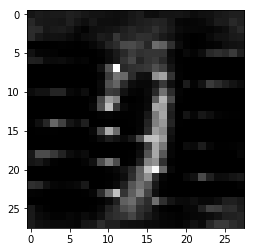

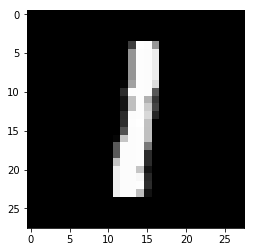

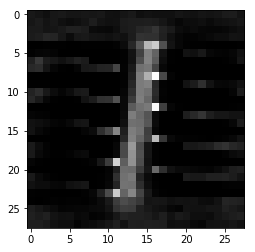

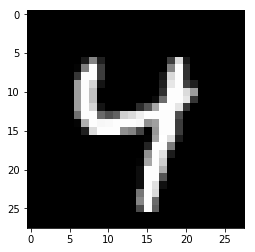

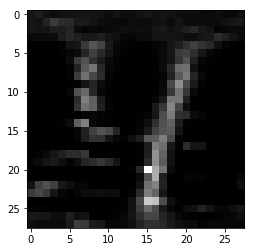

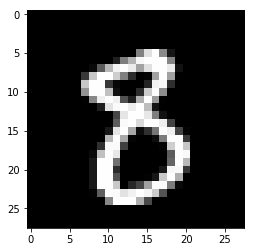

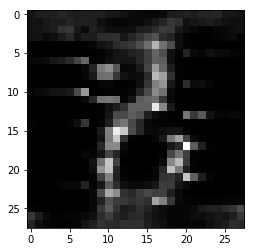

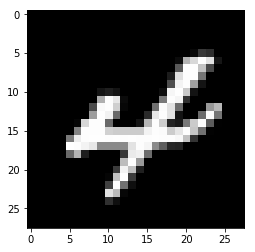

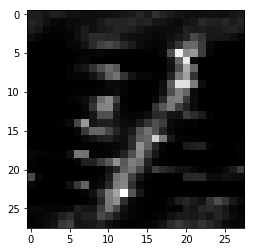

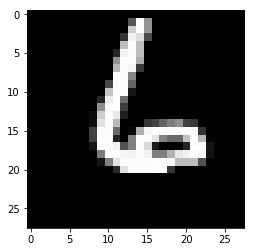

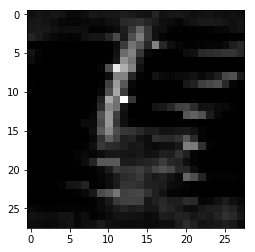

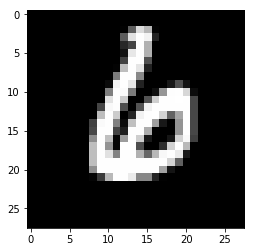

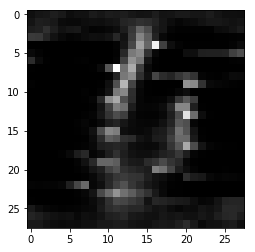

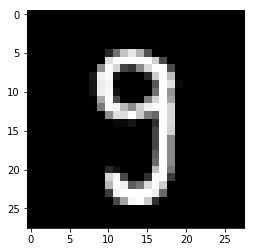

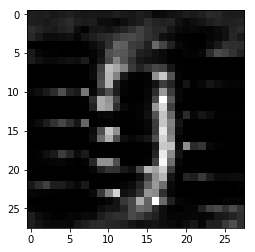

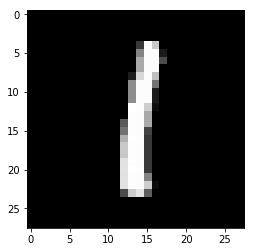

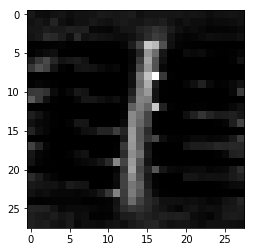

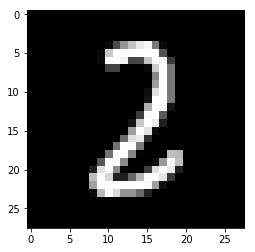

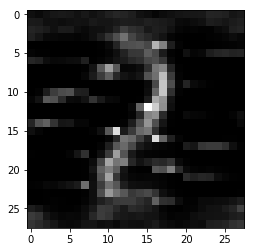

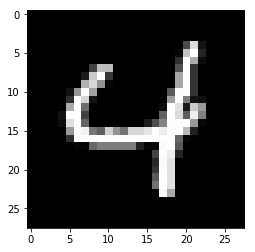

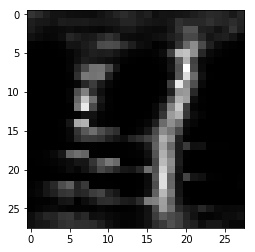

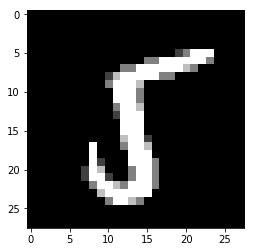

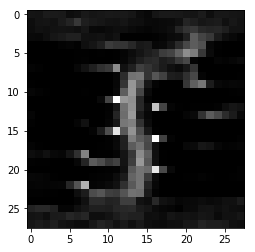

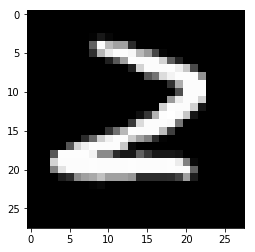

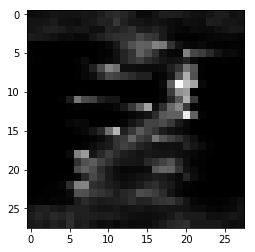

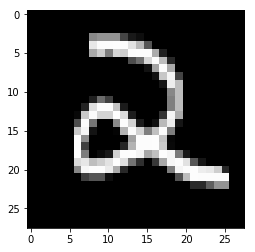

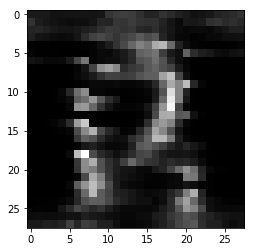

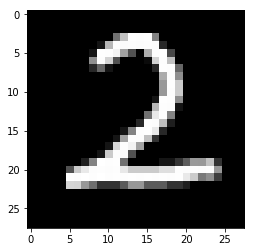

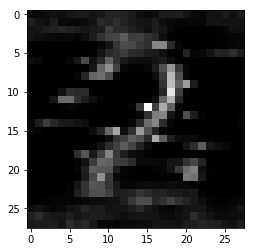

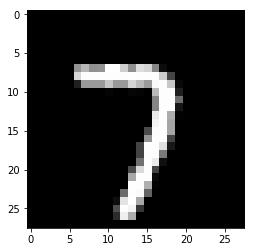

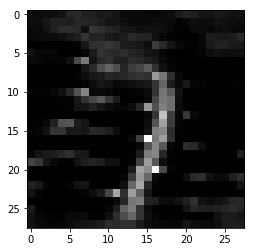

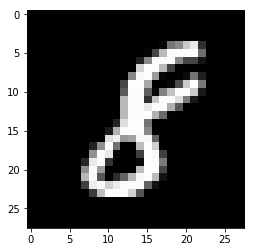

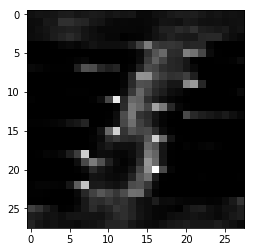

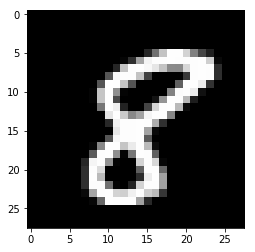

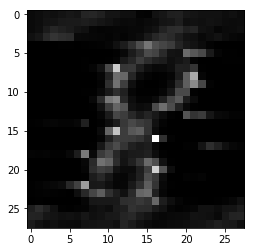

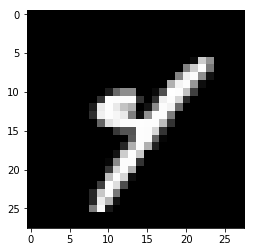

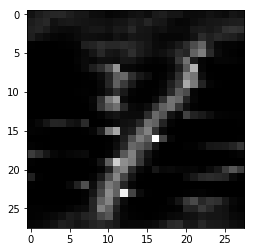

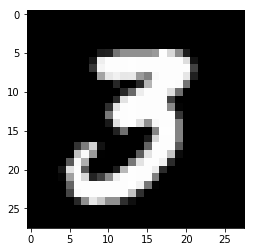

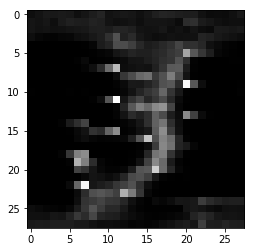

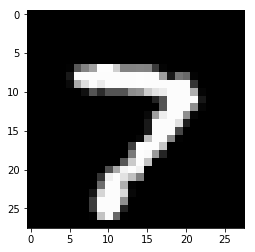

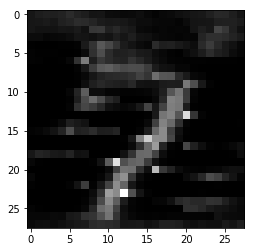

KeyboardInterrupt: 

In [7]:
train_neural_network(x)